TOPICOS QUE PODEM SER INTERESSANTES:
- Ver como se comportam as networks com palavras com mais que um significado.
- Existem networks, por exemplo, de cenas relacionadas com racismo? Se sim, pode ser usado para detenção. (MOTIFS)
- Falar de que temos um set de bues palavras mas um texto nao usa tantas palavras, procurar quantas palavras diferentes costuma ter um texto e criar uma random network com isso.
- Link Analysis

## FONTES LIVROS:

* The Fellowship Of The Ring: https://github.com/ganesh-k13/shell/blob/master/test_search/www.glozman.com/TextPages/01%20-%20The%20Fellowship%20Of%20The%20Ring.txt
* Lusiadas: https://github.com/rlafuente/textan/blob/master/sources/antero.txt
* Ode Triunfal: http://arquivopessoa.net/textos/2459
* Lusiadas - English Translation: https://www.gutenberg.org/files/32528/32528-h/32528-h.htm
* Memorial do Convento - https://docs.google.com/document/d/1vbG6B-OmWxcj1KaXeckznkoJWgtA5QprtyBucAQBtJM/edit?pli=1

In [12]:
import sys

# # Install requirements.txt
# !"{sys.executable}" -m pip install -r requirements.txt

# !python -m textblob.download_corpora

In [13]:
from IPython.display import display, HTML
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import random
import json
import tqdm


from src.network_properties import EvaluateNetworks
from src.random_text import get_text as get_random_text
from src.text_to_network import get_network
from src.file_to_text import read_file

## Network Properties:

In order to compare all the networks, we're going to utilize the following metrics/properties:

1. Degree Distribuition + Average Degree: 

    É importante definir 3 situações: Um node só tem degree 1 se for um node no inicio ou no final de TODO o texto + não se repetindo. Um node tem degree 2 se for uma palavra que só se repete uma única vez no texto. Sempre que uma palavra se repete, terá sempre degree ímpar, considerando que se a palavra após for uma palavra que também estava após da mesma palavra numa recorrência anterior é considerada um novo edge.

    Probabilidade de haver um node com degree n > 2, num set de K palavras: $$P(k,n)=\frac{1}{\prod_{i=0}^{n-2}k-i}\times(\frac{1}{k})^{n}$$

2. Average Path Length + Diameter:

3. Clustering Coefficient:

4. Connected Components:
We're expecting to have one connected component for any big enough network, so we are not going to consider this metric to be a valid one for comparing networks

5. Subgraph distribution:
This may be a fingerprit of the author/publisher of the text. Further explore

6. Z-Score for most relevant motif

7. Degree Centrality

8. Betweeness Centrality

9. Shortest Path Distribution


In [39]:
evaluations=[
    'degree_distribution',
    'avg_path_length',
    'diameter',
    'clustering_coefficient',
    'z_score',
    'motif_frequency',
    'degree_centrality',
    'betweenness_centrality',
    'shortest_path_distribution',
    'communities_number',
    'average_community_size'
]

## Understanding Real Network Example

We're going to analyze a real text (Fellowship of the ring) to first get a understanding of some underlying features that make a word adjacency network real.

After that, we'll try to build a model which generates a network similar to the real one.

### Reading the dataset

In [15]:
# Fellowship Of The Ring for random network definition purposes:
real_text = read_file('./data/The Fellowship Of The Ring.txt')

# number of words
n_words = len(real_text.words)
print('Fellowship Of The Ring has: ' + str(n_words) + ' words.')

# number of distinct words
n_distinct_words = len(set(real_text.words))
print('Fellowship Of The Ring has: ' + str(n_distinct_words) + ' distinct words.')

# Uniting all the words that were extracted creating what we called a "giga_phrase", a phrase that represents the entire book without paragraphs, periods or chapters
giga_phrase = ' '.join(real_text.words)
real_network = get_network(giga_phrase, weighted=False)

n_edges = len(real_network.edges)
print(f'Fellowship Of The Ring has: {n_edges} edges [graph generated]')

Fellowship Of The Ring has: 179543 words.
Fellowship Of The Ring has: 9131 distinct words.
Fellowship Of The Ring has: 78027 edges [graph generated]


### Visualizing the network

In order to further understand the network, we've store the network object in a format GEPHI can read, and analyzed it there and we got the bellow network visualization


![](./data/imgs/LOTR.png)

### Network Properties

We're going to obtain all the properties using the class `EvaluateNetworks` defined in the file [./src/network_properties.py](./src/network_properties.py)

  <00.00 sec> Calculating: <degree_distribution>


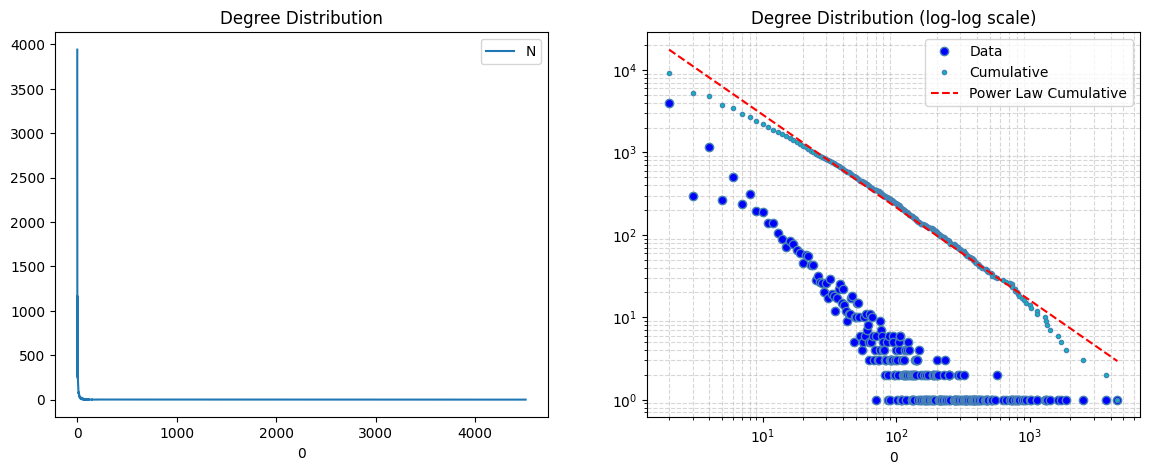

  <00.70 sec> Calculating: <avg_path_length>


    Finding Paths: 100%|██████████| 9131/9131 [03:48<00:00, 39.91it/s]


  <228.48 sec> Calculating: <diameter>
  <228.48 sec> Calculating: <clustering_coefficient>


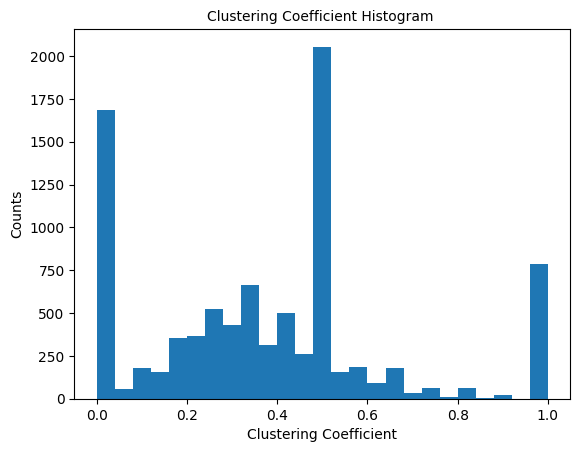

  <238.73 sec> Calculating: <degree_centrality>


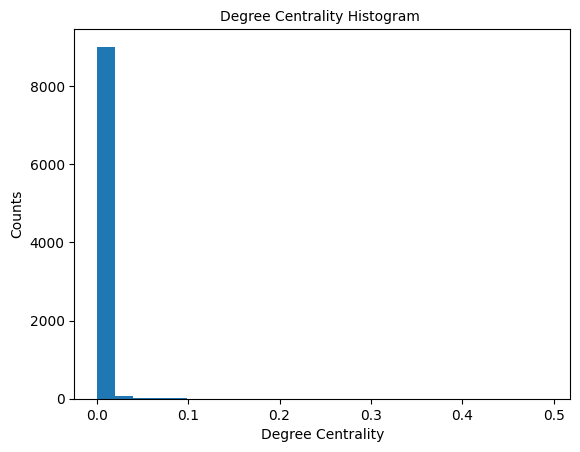

  <238.97 sec> Calculating: <betweenness_centrality>


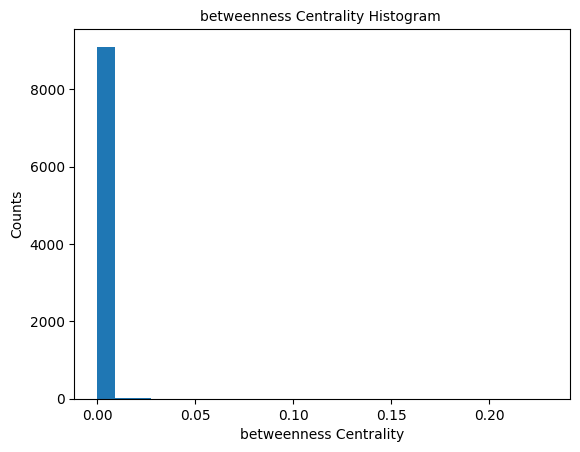

  <469.59 sec> Calculating: <shortest_path_distribution>


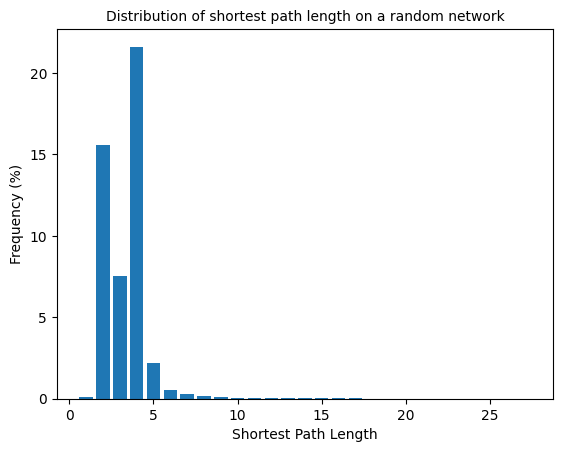

  <475.61 sec> Calculating: <communities_number>
  <478.62 sec> Calculating: <average_community_size>


Metric,Value
PowerLaw Exponent,-2.127530
Average Degree,17.090571
Average Path Length,3.183700
Diameter,27.000000
Average Clustering Coefficient,0.377398
Average Degree Centrality,0.001872
Betweeness Centrality,0.000239
Number of Communities,1017.000000
Average Community Size,8.978368


In [40]:
real = EvaluateNetworks(real_network, evaluations=evaluations)

# For betweenness centrality we're only using about 30% of nodes to speed up the process (by our tests, this gives very good approximation)
# motif_size -> Which motif_sizes to search using gTrie
evals = real.evaluate(plots=True, prints=False, betweenness_k=3000, motif_size=3, plot_motif_frequencies=True)     

html_output = pd.DataFrame.from_dict(evals, orient='index').reset_index().rename(columns={'index': 'Metric', 0: 'Value'})
html_output = html_output.to_html(index=False).replace('&lt;', '<').replace('&gt;', '>')
display(HTML(html_output))

### Visualizing the dataset

Visualizing the network using the `nx.draw` method from the library `networkx`. This gives us a brief understanding of what the network is like and allows us to more accurately choose models


In [ ]:
nx.draw(real_network)
plt.show()

## Network models

In this section, we'll try to experiment with different models to visualize if we can find a model which represents the word adjacency network (either generate the network directly, or by generating a text)

### Text Generating models

First we'll approach the model searching by generating random sentences using the English dictionary. In here we are trying to find some logic behind the text construction which may lead to a network similar to the real network. By finding a list of rules which generate a network similar to the real one, we may be able to generate a new language, or not, who knows?


#### Uniform Distribution

In this section, we'll analyze how a text where each word has been randomly selected behaves so that we can compare it with a actual network

Text with 100 words

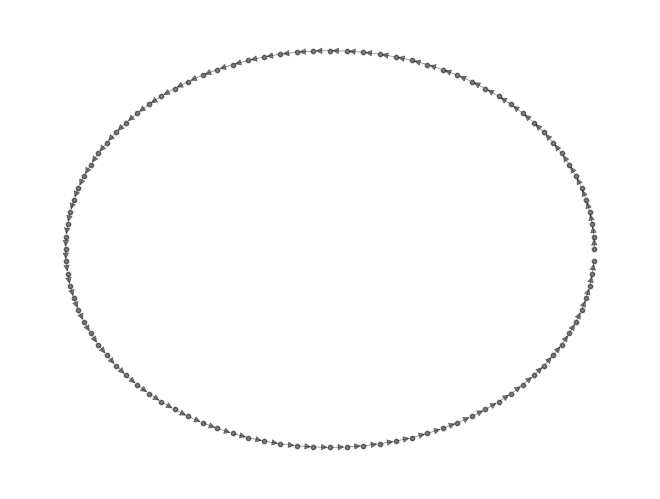

In [35]:
text = get_random_text(size=100)

network = get_network(text, weighted=False)

options = {
    'node_color': 'black',
    'node_size': 10,
    'width': 0.5,
    'alpha': 0.5,
}
nx.draw_circular(network, **options)
plt.show()

Text with 10000 different words

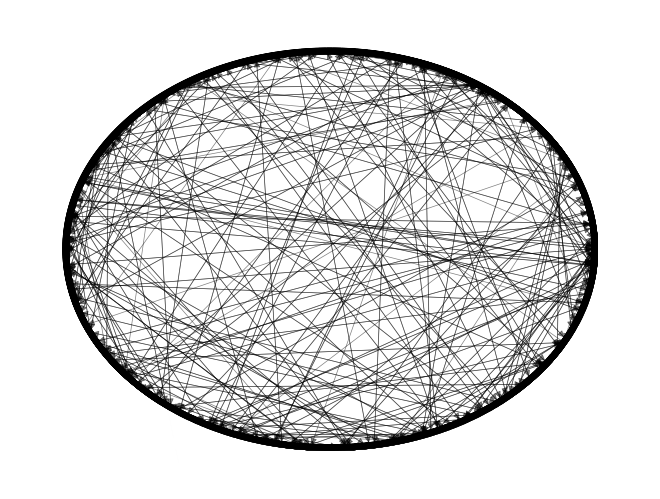

In [36]:
text = get_random_text(size=10000)

network = get_network(text, weighted=False)

nx.draw_circular(network, **options)
plt.show()

##### Brief Summary

After analyzing the above-generated network, we can conclude usual texts definitely behave differently than total randomness (as expected of humans).
We'll further try to improve this random word generator to further understand real-world word frequency networks

For texts with small amount of words, every word is only connected with another word, which is not true in real world networks, and for the big texts, it does not represent real world networks.

#### Power Law distribution

Very similar to the above section, but using a Power-law distribution for the word frequency instead of a uniform one.

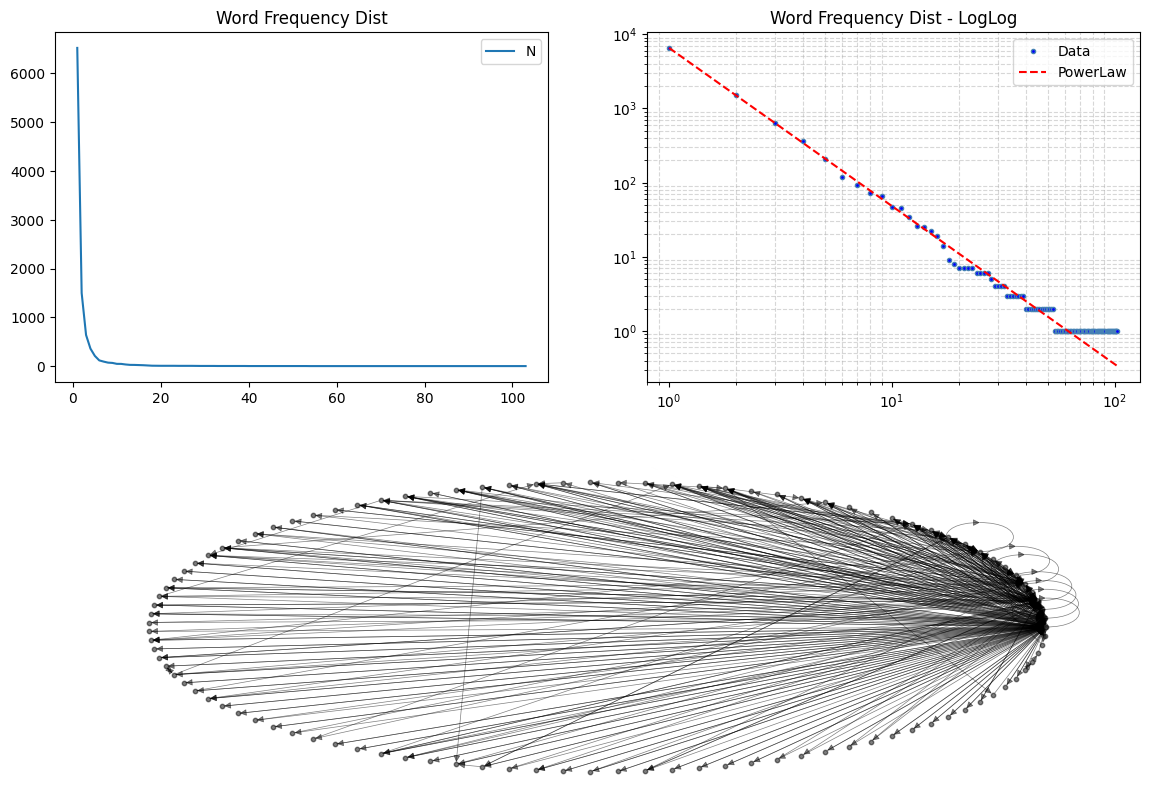

In [33]:
POWER_LAW_EXPONENT = 2.13

text = get_random_text(size=10000, power_law_exponent=POWER_LAW_EXPONENT)

# Verifying the text generated has word frequency obeying a power-law
frequencies = pd.DataFrame(text.split(" "))
frequencies['N'] = 0
frequencies = frequencies.groupby(by=[0]).count().sort_values(by=['N'], ascending=False).reset_index()

# In order to calculate logs, we need to start the index at 0, so adding 1 to all indexes
frequencies.index += 1
# Creating PowerLaw column
frequencies['PowerLaw'] = frequencies.apply(lambda row: frequencies['N'].iloc[0]*(row.name)**(-POWER_LAW_EXPONENT), axis=1)


gs = gridspec.GridSpec(2, 2, figure=plt.figure(figsize=(14, 10)))
ax = plt.subplot(gs[0, 1])
ax.grid(True, which="both", linestyle='--', alpha=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='minor', labelsize=8)


# Normal scale
frequencies.plot(title='Word Frequency Dist', y='N', ax=plt.subplot(gs[0, 0]), xlabel=None)
# Log-log scale
frequencies.plot(
    title='Word Frequency Dist - LogLog'
    ,ax=ax
    ,loglog=True
    ,markersize=3
    ,markeredgecolor='steelblue'
    ,xlabel=None
    ,y=['N', 'PowerLaw']
    ,label=['Data', 'PowerLaw']
    ,style=['bo', 'r--']
)

# Plot network
network = get_network(text, weighted=False)
options = {
    'node_color': 'black',
    'node_size': 10,
    'width': 0.5,
    'alpha': 0.5,
}
nx.draw_circular(network, ax=plt.subplot(gs[1, :]), **options)

plt.show()

To try and understand a bit more if the network generated looks how a random text with power-law frequency distribution should behave, we're gonna scramble the words a few times and generate new networks to visualize the network generated.

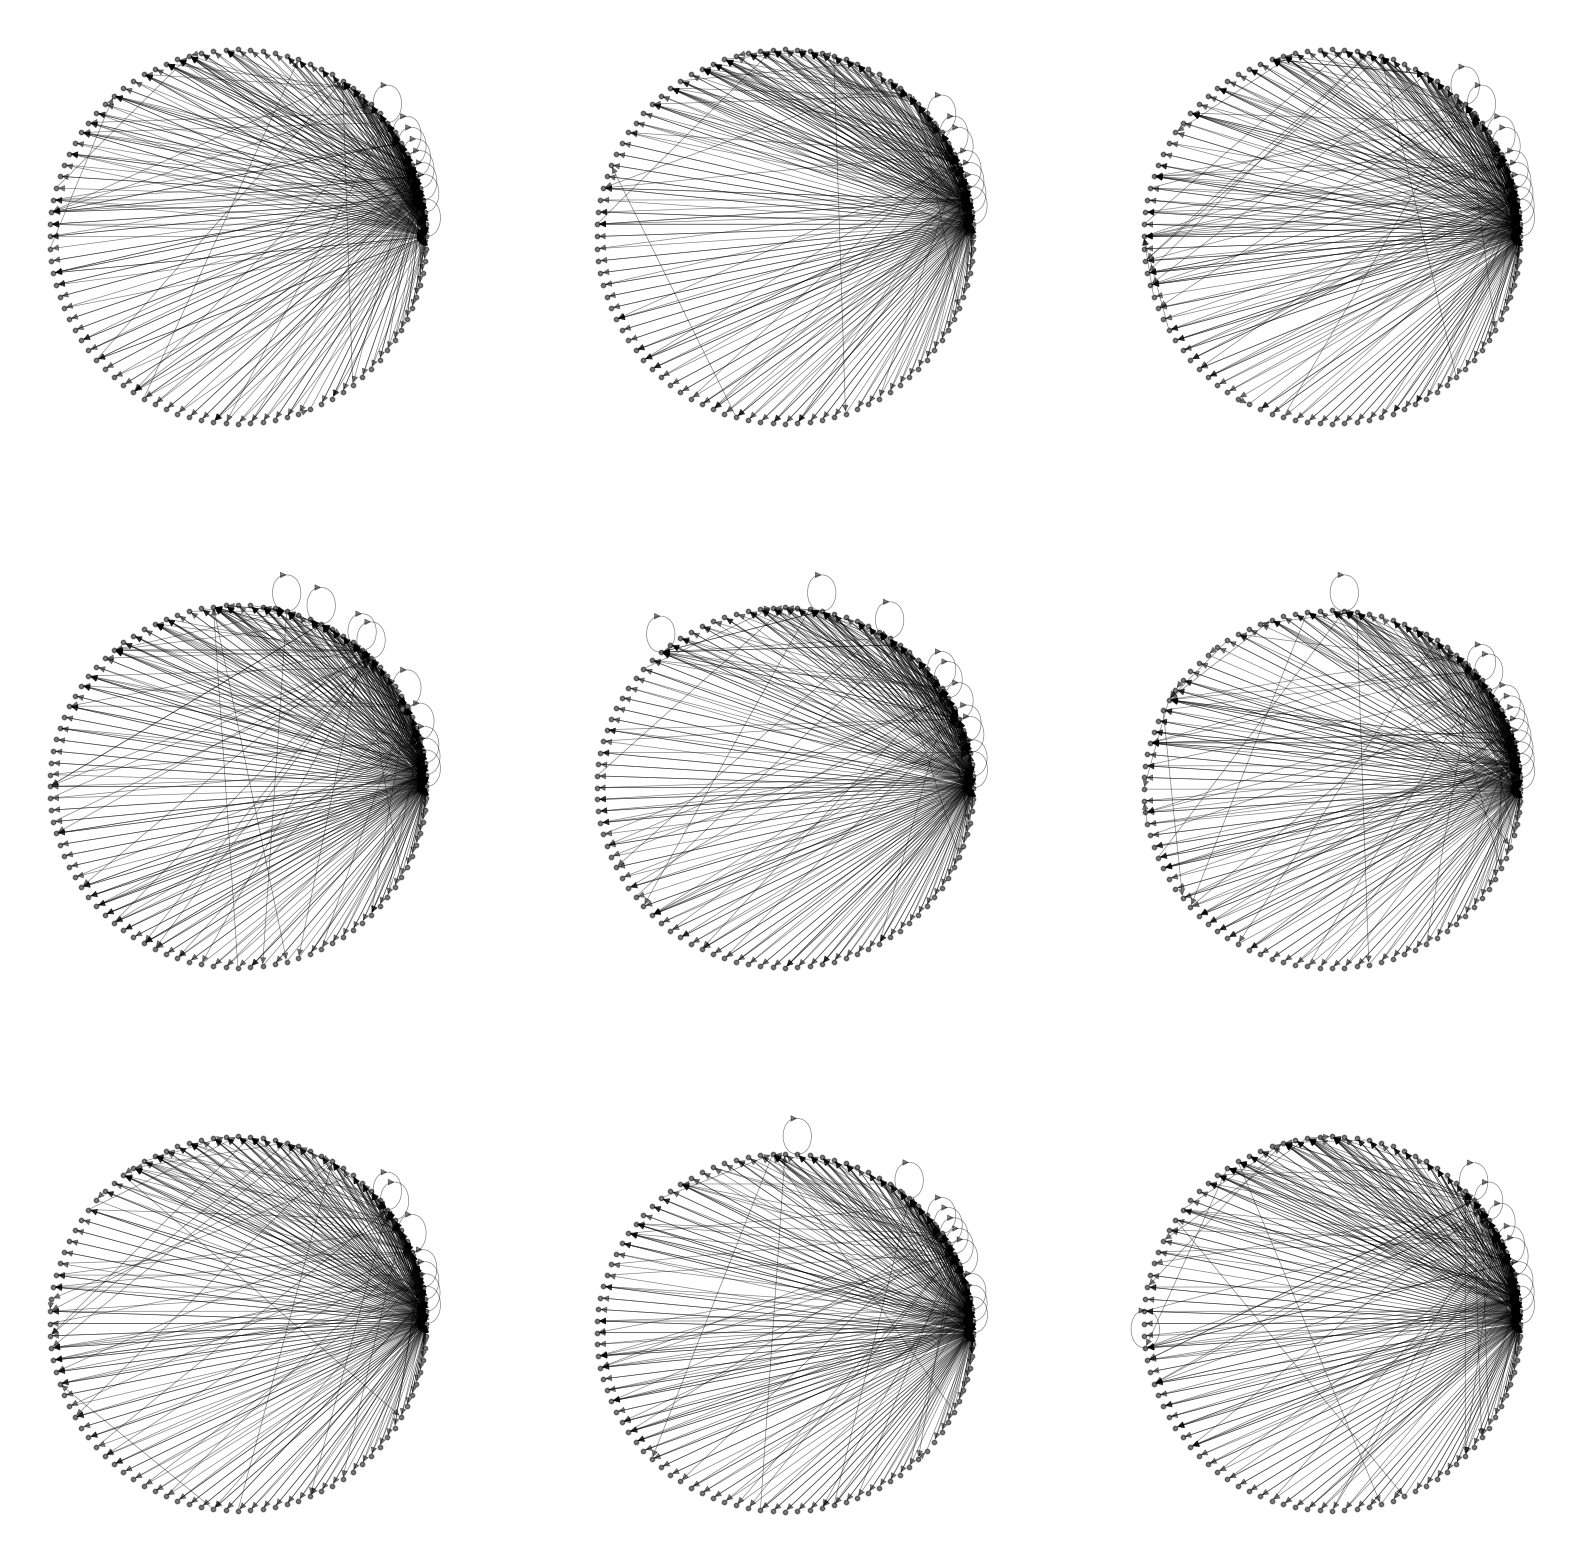

In [18]:
N_TRIES = 9
ncols = 3
# Using number of cols and total number of tries, generate number of rows
nrows = N_TRIES//ncols + min(1, N_TRIES%ncols)


aux = text.split(" ")

# Iterate through number of tries
(_, axs) = plt.subplots(ncols=ncols, nrows=nrows, figsize=(20,20))
for i in range(N_TRIES):
    random.shuffle(aux)

    network = get_network(' '.join(aux), weighted=False)
    nx.draw_circular(network, ax=axs[i//nrows][i%ncols], **options)

plt.show()

##### Brief Summary

After analyzing the above-generated networks, we can see that the well-known Power Law distribution is not enough to describe a real-world network for word adjacency.

This goes to show that human language is much more complex than what simple models may describe. We'll try to further improve our model to copy more properties of real-world texts to try and find a simple model which more accurately describes the real world word-adjacency networks. 

Another point to note:
* There exists self-loops with this model, we have to think of a way to remove this
* We need to add some way of creating ponctuation which separates words.
* Even though word frequency appears to follow a power-law distribution, there's more to it than that due to the fact that humans tend to try not to repeat words very frequently.

### Graph Generators

In this section we will generate some graphs using different models keeping some characteristics from the network generated from the real Network example (Fellowship of the ring)

In [44]:
# Calculating some variables to use for parameters in the networks bellow

# Number of nodes
N = len(real_network.nodes)
# Number of edges
E = len(real_network.edges)

# Average Clustering Coefficient
C = np.mean(list(real._clustering_coefficient.values()))

#### Erdős-Rényi Graph

Generating and visualizing a $G_{n,p}$ graph.
We'll use the following values:
* $n=9131$ (from the *Fellowship of the Ring* network)
* $p=9131/78027\approx0.117$ (using number of edges from the network generated and number of nodes)

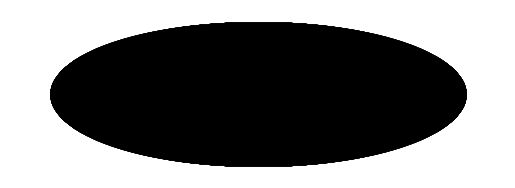

In [37]:
n = N
p = N / E # Number of nodes / number of edges


erdos_gn_network = nx.erdos_renyi_graph(n, p, directed=False)

nx.draw_circular(erdos_gn_network, ax=plt.subplot(gs[1, :]), **options)

plt.show()

##### Brief Summary

The network doesn't look like any real world network (in fact, we can't even visualize the network). Due to that fact, we won't use it in the remainder of this report.

#### Small world Graph

Generating and visualizing a Newman–Watts–Strogatz small-world graph. We'll use the following values:
* $n=9131$
* $k=3$
* $p=0.99$

**Notes**
 
The value of $k$ was calculated using the fact that the clustering coefficient of this model is (for the first lattice generated) $C(0)=\frac{3(K-2)}{4(K-1)}$ and that the Average clustering coefficient of our real network is $C\approx0.377$, we can derive a good start for the value of $K$ by using $0.377=\frac{3(K-2)}{4(K-1)}\iff K=\frac{4\times0.377-6}{4\times0.377-3}\iff k\approx 3$


The value of $p$ was obtained due to the fact that the average path length for different $p$ values is: 

1. $path(p=0)\approx\frac{N}{2K}=\frac{9131}{2\times3.01}\approx1516$ 
1. $path(p=1)\approx\frac{\ln(N)}{\ln(K)}=\frac{\ln(9131)}{\ln(3.01)}\approx8$

Knowing that we have a average path length of $\approx3.18$ for the real network, we used $p=0.99$, which still does not allow for our average path length, but it's the closest one

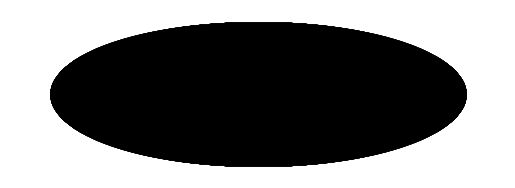

In [47]:
n = N
k = int(np.round(((4*C-6)/(4*C-3))))
p = 0.99

newman_watts_network = nx.newman_watts_strogatz_graph(n, k, p)

nx.draw_circular(newman_watts_network, ax=plt.subplot(gs[1, :]), **options)

plt.show()

##### Brief Summary

The network doesn't look like any real world network (in fact, we can't even visualize the network). Due to that fact, we won't use it in the remainder of this report.

#### Barabási–Albert Preferential Attachment

Generating and visualizing a Barabási–Albert preferential attachment graph, using the following values:
* $n = 9131$
* $m = 3$

The value of $m$ (number of edges to attach from a new node to existing nodes) was calculated using the fact that the Average clustering coefficient for the BA model is $C=m^{-1}$. Knowing the clustering coefficient of our real network, we have $0.377=m^{-1}\implies m\approx 2.65\approx 3$


Source: https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model

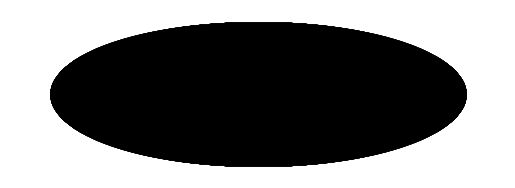

In [50]:
n = N
m = int(np.round(1/C))

ba_network = nx.barabasi_albert_graph(n, m)

nx.draw_circular(ba_network, ax=plt.subplot(gs[1, :]), **options)

plt.show()

##### Brief Summary

The network doesn't look like any real world network (in fact, we can't even visualize the network). Due to that fact, we won't use it in the remainder of this report.

#### Power Law Cluster Graph

https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.powerlaw_cluster_graph.html#networkx.generators.random_graphs.powerlaw_cluster_graph

## Random Analysis

In [ ]:
def random_analysis(n):
    avg_list = []
    avg_path_lengths_list = []
    diameter_list = []
    avg_degree_centrality_list = []

    # Create a new figure for avg_list
    fig_avg, ax_avg = plt.subplots()

    # Create a new figure for avg_degree_centrality_list
    fig_degree, ax_degree = plt.subplots()

    # Create a new figure for avg_path_lengths_list
    fig_path_length, ax_path_length = plt.subplots()

    # Create a new figure for diameter_list
    fig_diameter, ax_diameter = plt.subplots()

    for i in range(n):
        # generate a random network for the current step
        number_set = [str(num) for num in random.sample(range(1, n_distinct_words + 1), n_distinct_words)]
        random_text = ' '.join(random.choices(number_set, k=n_words))
        network = get_network(random_text, weighted=False)
        # calculate the average degree
        avg_degree = np.mean([d for _, d in network.degree()])
        # calculate the average shortest path
        shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(network))
        average_path_lengths = [np.mean(list(spl.values())) for spl in shortest_path_lengths.values()]
        avg_path_lengths = np.mean(average_path_lengths)
        # calculate the diameter
        diameter = max(nx.eccentricity(network, sp=shortest_path_lengths).values()) 
        # calculate average degree centrality
        degree_centrality = nx.centrality.degree_centrality(network)
        average_degree_centrality = np.mean(list(degree_centrality.values()))
        # add the values to their lists
        avg_list.append(avg_degree)
        avg_path_lengths_list.append(avg_path_lengths)
        diameter_list.append(diameter)
        avg_degree_centrality_list.append(average_degree_centrality)

    # Set y-axis label
    ax_avg.set_ylabel('Value')
    ax_degree.set_ylabel('Value')
    ax_path_length.set_ylabel('Value')
    ax_diameter.set_ylabel('Value')

    # Set plot title
    ax_avg.set_title('avg_degree')
    ax_degree.set_title('avg_degree_centrality')
    ax_path_length.set_title('avg_path_length')
    ax_diameter.set_title('avg_diameter')

    # Plot avg_list in fig_avg
    ax_avg.boxplot(avg_list)

    # Plot avg_degree_centrality_list in fig_degree
    ax_degree.boxplot(avg_degree_centrality_list)

    # Plot avg_path_lengths_list in fig_path_length
    ax_path_length.boxplot(avg_path_lengths_list)

    # Plot diameter_list in fig_diameter
    ax_diameter.boxplot(diameter_list)

    # Display the plots
    plt.show()


# random_analysis(100)

## Real Network Analysis

In this section, we'll try to analyze and summarize some of the real networks we found (some portuguese, some english some french).

The full list of books/texts analyzed is:

* Lusiadas by Luis de Camoes (Portuguese)
* Lusiadas (English Translation) by Luis de Camoes, translated by William Julius Mickle (English)
* Memorial do Convento by Jose Saramago (Portuguese)
* Ode Triunfal by Fernando Pessoa (Portuguese)
* The Fellowship of The Ring by J. R. R. Tolkien (English)

In order to analyze and better understand the underlying structure of each network, we generated 10 random networks for all the different models defined in the above section and calculated the averages of the metrics for those generated networks.

With this data, we're able to compare the metrics of the networks to a random network which contains some of the same features. By using this approach, we are able to identify the specific characteristics that are specific to real world networks.

In [6]:
# Evaluation Metrics

evaluations=[
    'degree_distribution',
    'avg_path_length',
    'diameter',
    'clustering_coefficient',
    # 'z_score',
    # 'motif_frequency',
    'degree_centrality',
    'betweenness_centrality',
    'shortest_path_distribution',
    'communities_number',
    'average_community_size'
]

# Which evaluations to execute on random networks
random_nets_evals = [
    'degree_distribution',
    'clustering_coefficient',
    'degree_centrality',
    'communities_number',
    'average_community_size'
]

# Ratio of text size/word set to keep from original text when generating random networks
SAMPLE_RATIO = 0.2
NUM_OF_RAND_NETWORKS = 100

Evaluating "The Fellowship Of The Ring"...
  <00.00 sec> Calculating: <degree_distribution>
  <00.02 sec> Calculating: <avg_path_length>


    Finding Paths: 100%|██████████| 9131/9131 [03:01<00:00, 50.45it/s]


  <167.62 sec> Calculating: <diameter>
  <167.62 sec> Calculating: <clustering_coefficient>
  <173.38 sec> Calculating: <degree_centrality>
  <173.39 sec> Calculating: <betweenness_centrality>
  <531.42 sec> Calculating: <shortest_path_distribution>


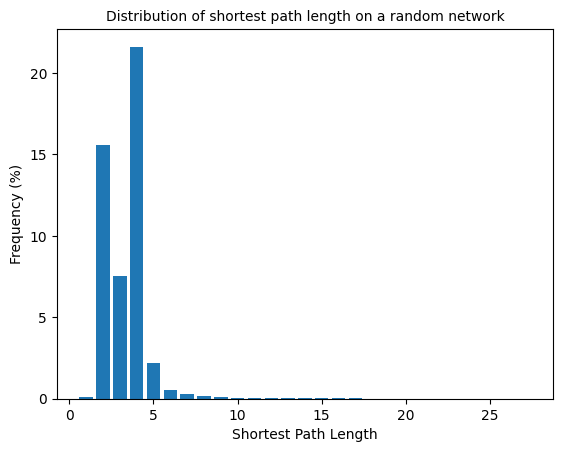

  <534.81 sec> Calculating: <communities_number>
  <535.86 sec> Calculating: <average_community_size>


  Generating Random networks: 100%|██████████| 100/100 [07:35<00:00,  4.56s/it]


Evaluating "Lusiadas"...
  <00.00 sec> Calculating: <degree_distribution>
  <00.00 sec> Calculating: <avg_path_length>


    Finding Paths: 100%|██████████| 9726/9726 [01:38<00:00, 98.61it/s] 


  <98.69 sec> Calculating: <diameter>
  <98.69 sec> Calculating: <clustering_coefficient>
  <100.03 sec> Calculating: <degree_centrality>
  <100.03 sec> Calculating: <betweenness_centrality>
  <380.20 sec> Calculating: <shortest_path_distribution>


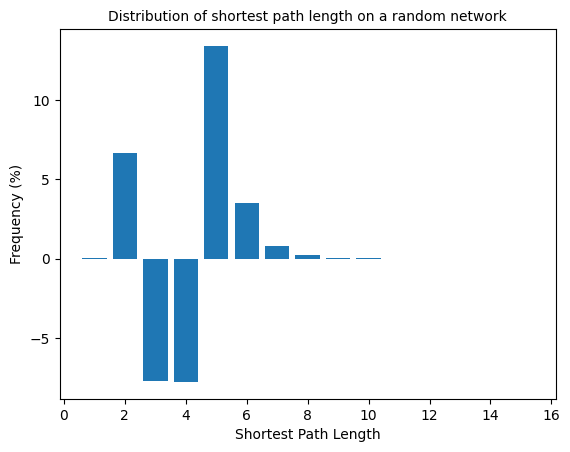

  <383.97 sec> Calculating: <communities_number>
  <384.64 sec> Calculating: <average_community_size>


  Generating Random networks: 100%|██████████| 100/100 [02:54<00:00,  1.75s/it]


Evaluating "Lusiadas - English Translation"...
  <00.00 sec> Calculating: <degree_distribution>
  <00.02 sec> Calculating: <avg_path_length>


    Finding Paths: 100%|██████████| 14309/14309 [04:16<00:00, 55.73it/s]


  <256.84 sec> Calculating: <diameter>
  <256.84 sec> Calculating: <clustering_coefficient>
  <261.72 sec> Calculating: <degree_centrality>
  <261.73 sec> Calculating: <betweenness_centrality>
  <891.88 sec> Calculating: <shortest_path_distribution>


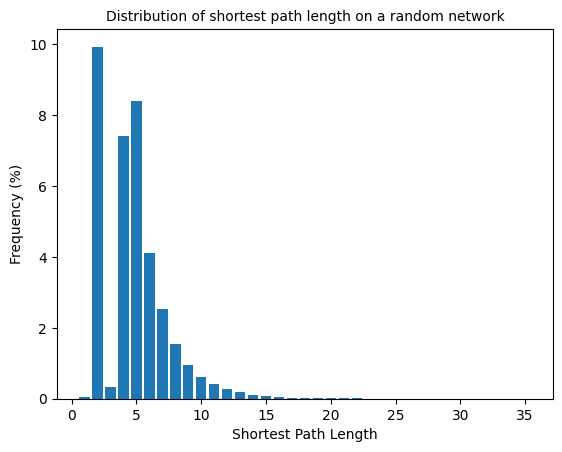

  <899.62 sec> Calculating: <communities_number>
  <900.92 sec> Calculating: <average_community_size>


  Generating Random networks: 100%|██████████| 100/100 [06:29<00:00,  3.90s/it]


Evaluating "Ode Triunfal"...
  <00.00 sec> Calculating: <degree_distribution>
  <00.00 sec> Calculating: <avg_path_length>


    Finding Paths: 100%|██████████| 829/829 [00:00<00:00, 1717.83it/s]


  <00.48 sec> Calculating: <diameter>
  <00.48 sec> Calculating: <clustering_coefficient>
  <00.48 sec> Calculating: <degree_centrality>
  <00.48 sec> Calculating: <betweenness_centrality>
  <01.45 sec> Calculating: <shortest_path_distribution>


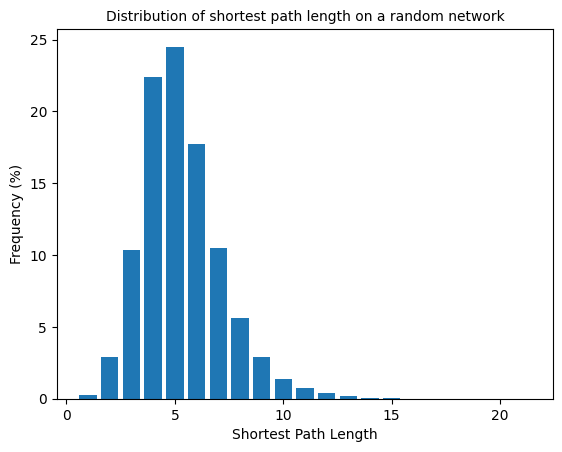

  <01.56 sec> Calculating: <communities_number>
  <01.58 sec> Calculating: <average_community_size>


  Generating Random networks: 100%|██████████| 100/100 [00:05<00:00, 18.77it/s]


Evaluating "Memorial do Convento"...
  <00.00 sec> Calculating: <degree_distribution>
  <00.00 sec> Calculating: <avg_path_length>


    Finding Paths: 100%|██████████| 7271/7271 [00:47<00:00, 154.01it/s]


  <47.27 sec> Calculating: <diameter>
  <47.27 sec> Calculating: <clustering_coefficient>
  <48.00 sec> Calculating: <degree_centrality>
  <48.02 sec> Calculating: <betweenness_centrality>
  <167.97 sec> Calculating: <shortest_path_distribution>


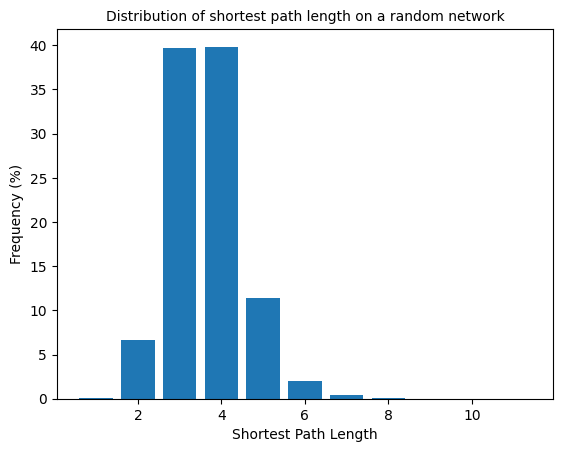

  <170.06 sec> Calculating: <communities_number>
  <170.48 sec> Calculating: <average_community_size>


  Generating Random networks: 100%|██████████| 100/100 [01:43<00:00,  1.04s/it]


Evaluating "Tabacaria"...
  <00.00 sec> Calculating: <degree_distribution>
  <00.02 sec> Calculating: <avg_path_length>


    Finding Paths: 100%|██████████| 590/590 [00:00<00:00, 2479.00it/s]


  <00.25 sec> Calculating: <diameter>
  <00.25 sec> Calculating: <clustering_coefficient>
  <00.25 sec> Calculating: <degree_centrality>
  <00.25 sec> Calculating: <betweenness_centrality>
  <00.64 sec> Calculating: <shortest_path_distribution>


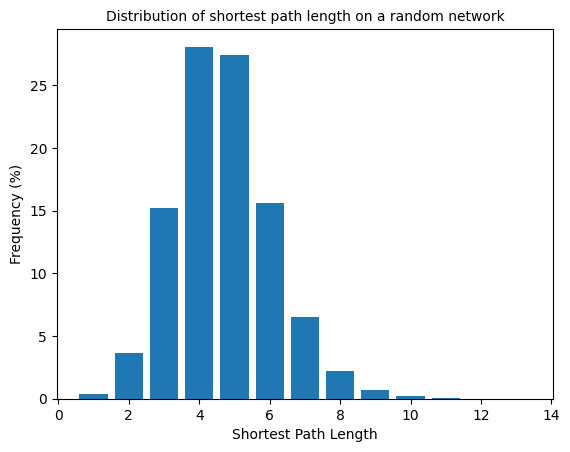

  <00.73 sec> Calculating: <communities_number>
  <00.75 sec> Calculating: <average_community_size>


  Generating Random networks: 100%|██████████| 100/100 [00:04<00:00, 22.90it/s]


Book,Author,Language,#Nodes,#Words,#Edges,PowerLaw Exponent,Average Degree,Average Path Length,Diameter,Average Clustering Coefficient,Average Degree Centrality,Betweeness Centrality,Number of Communities,Average Community Size,rnd_text - PowerLaw Exponent,rnd_text - Average Degree,rnd_text - Average Clustering Coefficient,rnd_text - Average Degree Centrality,rnd_text - Number of Communities,rnd_text - Average Community Size,rnd_powerlaw - PowerLaw Exponent,rnd_powerlaw - Average Degree,rnd_powerlaw - Average Clustering Coefficient,rnd_powerlaw - Average Degree Centrality,rnd_powerlaw - Number of Communities,rnd_powerlaw - Average Community Size,rnd_sample - PowerLaw Exponent,rnd_sample - Average Degree,rnd_sample - Average Clustering Coefficient,rnd_sample - Average Degree Centrality,rnd_sample - Number of Communities,rnd_sample - Average Community Size,Translator
The Fellowship Of The Ring,J. R. R. Tolkien,English,9131,179543,78027,-2.127530,17.090571,3.183700,27,0.377398,0.001872,0.000239,1017,8.978368,-4.989697091033393 +/- 0.33550084723094575,39.11794085432639 +/- 0.01835118204934981,0.011258945284606659 +/- 0.00011266928595910712,0.02143448813935693 +/- 1.0055442218822351e-05,17.36 +/- 4.148541912527823,110.82231213206634 +/- 24.851205271004417,-2.402049066023643 +/- 0.056799218796767796,44.28123168583642 +/- 0.23667004539204642,0.03716097690303059 +/- 0.0009998160043337534,0.02783269504739307 +/- 0.0002979149952551303,39.42 +/- 8.021446253637807,42.1970967636429 +/- 9.286675198474434,-2.138612637114535 +/- 0.00818598385628086,12.693556874656089 +/- 0.10040355572211952,0.3183896424169891 +/- 0.0056863046863397096,0.0029655785754545993 +/- 4.6219847744001834e-05,864.1 +/- 23.737101760745773,4.958402002722329 +/- 0.12013476142000683,NaN
Lusiadas,Luis de Camoes,Portuguese,9726,57852,41778,-2.182286,8.590993,3.728039,15,0.220709,0.000883,0.000281,2110,4.609479,-3.552285709877939 +/- 0.18845395803566323,11.90958787414743 +/- 0.014292704569599225,0.003569013736827059 +/- 0.0002414243735555275,0.006142428685430928 +/- 1.3843001265223469e-05,720.36 +/- 47.47241725465431,2.709810917626443 +/- 0.2590465439672082,-2.9634203496389713 +/- 0.13749623341472428,15.373595479491676 +/- 0.1046819643241851,0.011808641647034532 +/- 0.000833148414771738,0.010276562450248366 +/- 0.0001383125267088478,154.49 +/- 20.876539464192817,9.86362519081712 +/- 1.3046055237534513,-2.2133800437053557 +/- 0.008214494113827723,5.715712974302372 +/- 0.05063820332252184,0.13710069599374805 +/- 0.0054414362676740696,0.0015673026678095674 +/- 2.8667182459287078e-05,1103.54 +/- 22.489739882888816,3.307170018564654 +/- 0.05576874018973144,NaN
Lusiadas - English Translation,Luis de Camoes,English,14309,134556,80453,-2.174588,11.245091,3.873856,35,0.236665,0.000786,0.000201,2587,5.531117,-3.4788339892399547 +/- 0.22385462724167693,18.782105839504638 +/- 0.005986795194746602,0.003647482775101738 +/- 0.00011420650414358549,0.006567767324933625 +/- 2.839110269836023e-06,802.05 +/- 277.5900349436197,4.187108939343674 +/- 2.010367374185703,-2.832188617839586 +/- 0.10058172137711335,22.9767022944567 +/- 0.11299411736834548,0.012165008533658879 +/- 0.000565394977775175,0.009870370688081255 +/- 9.751072236738061e-05,127.89 +/- 18.497510643327118,18.615595311688832 +/- 2.84442707084645,-2.20808252061659 +/- 0.006334180633153862,7.4533194602562345 +/- 0.052935311547572354,0.20938611178338565 +/- 0.005355195681359417,0.0012361354407964872 +/- 1.7942012451570162e-05,1539.06 +/- 32.76059218023997,3.9200935844938 +/- 0.0667482006044266,William Julius Mickle
Ode Triunfal,Fernando Pessoa - Álvaro de Campos,Portuguese,829,1816,1604,-2.297919,3.869723,5.298079,21,0.065109,0.004674,0.005206,267,3.104869,-3.156175521192048 +/- 0.32599451120900996,4.91325497294203 +/- 0.10145194283935362,0.01962939398607554 +/- 0.0058754626280023686,0.033820400070857855 +/- 0.0014087688657374558,54.19 +/- 3.9056241498638853,2.714210824346566 +/- 0.18218284511414173,-2.696515257673501 +/- 0.182015455383

In [7]:
with open('./data/books_metadata.json', 'rb') as f:
    books = json.load(f)


for book in books.keys():
    print(f'Evaluating "{book}"...')
    # Get TextBlob from file
    text = read_file(f'./data/{book}.txt', encoding='utf-8')

    # Transform text into network
    network = get_network(' '.join(text.words), weighted=False)
    
    # Number of Nodes + Number of Word + Number of Edges
    books[book].update(
        {'#Nodes': len(set(text.words)), 
         '#Words': len(text.words),
         '#Edges': len(network.edges)
    })    
    # Add evaluation metrics to dictionary
    books[book].update(EvaluateNetworks(network, evaluations=evaluations).evaluate(plots=False, prints=False, motif_size=3))


    rnd_wordset = random.sample(list(set(text.words)), int(len(set(text.words))*SAMPLE_RATIO))
    rnd_wordsize = int(len(text.words)*SAMPLE_RATIO)

    rnd_net_vals = {
        'rnd_text': {}
        ,'rnd_powerlaw': {}
        ,'rnd_sample': {}
    }
    # random networks generation
    for _ in tqdm.tqdm(range(NUM_OF_RAND_NETWORKS), desc='  Generating Random networks'):

        # Completely Random Text keeping text size (num of words) and word set (distinct words)
        rnd_text = get_random_text(size=rnd_wordsize, words=rnd_wordset)
        # Random text keeping text size, word set and power law distribution for word frequency (using degree power law from original network)
        rnd_powerlaw = get_random_text(size=rnd_wordsize, power_law_exponent=books[book]['PowerLaw Exponent'], words=rnd_wordset)
        # Random shuffle of original text, with a sample of only "rnd_wordsize" words
        tmp = text.words.copy()
        random.shuffle(tmp)
        rnd_sample = ' '.join(tmp[:rnd_wordsize])


        for rnd_net in rnd_net_vals.keys():
            net = eval(f'get_network({rnd_net})')
            net_eval = EvaluateNetworks(net, evaluations=random_nets_evals).evaluate(plots=False, prints=False, print_evals=False)
            for metric in net_eval.keys():
                rnd_net_vals[rnd_net].setdefault(metric, [])

                # Append new measure to dictionary
                rnd_net_vals[rnd_net][metric].append(net_eval[metric])

    # Getting mean +/- std_dev for each network
    for rnd_net in rnd_net_vals.keys():
        for metric in rnd_net_vals[rnd_net].keys():
            books[book][f'{rnd_net} - {metric}'] = f'{np.mean(rnd_net_vals[rnd_net][metric])} +/- {np.std(rnd_net_vals[rnd_net][metric])}'

            


        

df = pd.DataFrame.from_dict(books, orient='index').reset_index(drop=False).rename(columns={'index':'Book'})
display(HTML(df.to_html(index=False).replace('&lt;', '<').replace('&gt;', '>')))